In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

In [2]:
plt.style.use('dark_background')

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

In [3]:
print("tensorflow version: {}".format(tf. __version__))

tensorflow version: 2.9.1


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


### Load Dataset

In [6]:
# dataset path
ROOT_DATASET = 'C:\\Users\\akunr\\Desktop\\U-Net'
os.listdir(ROOT_DATASET)

['.ipynb_checkpoints',
 'annotations_prepped_test',
 'annotations_prepped_train',
 'images_prepped_test',
 'images_prepped_train',
 'rtx_model.h5',
 'rtx_model2.h5',
 'U-Net_Final.ipynb']

In [7]:
img_path = ROOT_DATASET + '/images_prepped_train/'
annot_path = ROOT_DATASET + '/annotations_prepped_train/'

In [8]:
import glob

train_images_dir = glob.glob(img_path+'/*.png')
train_annotations_dir = glob.glob(annot_path+'/*.png')

In [9]:
train_images = []
for img in train_images_dir:
    n = cv2.imread(img)
    train_images.append(n)

In [10]:
train_annotations = []
for img in train_annotations_dir:
    n = cv2.imread(img)
    train_annotations.append(n)

In [11]:
def get_colored_segmentation_image(seg, colors,
                                    n_classes):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c)
                             * (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg[:, :, 0] == c)
                             * (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg[:, :, 0] == c)
                             * (colors[c][2])).astype('uint8')
    return seg_img

# initiate fix colors list
class_colors = [(128,0,0), (170,110, 40), (128,128,0), (0,128,128), (0,0,128), (230,25,75), (245,130,48), (255,255,25), (210,245,60), (240,50,230),
               (128,128,128), (220,190,255), (255,215,180), (70,140,240), (0,130,200)]

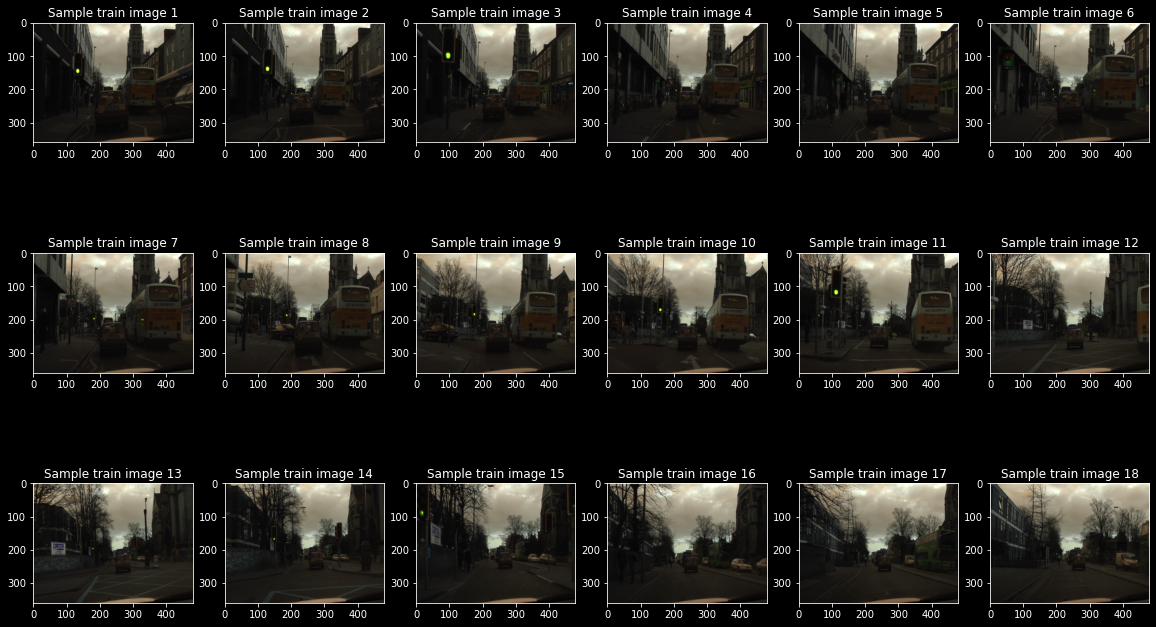

In [12]:
#Plot sample of train images
fig = plt.figure(figsize = (20,12))

for index in range(18):
    ax = fig.add_subplot(3,6,index+1)
    ax.set_title("Sample train image {}".format(index+1))
    ax.imshow(train_images[index], cmap='gray')

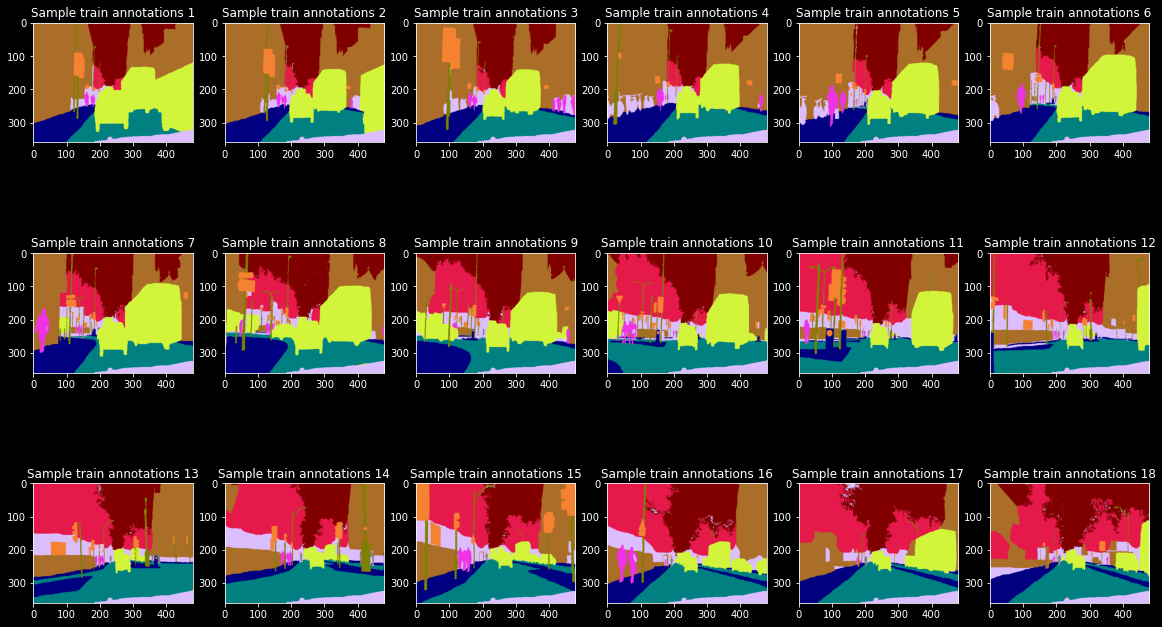

In [13]:
#Plot sample of train annotations
fig = plt.figure(figsize = (20,12))


for index in range(18):
#     image = mpimg.imread(os.path.join(train_annotations_dir, os.listdir(train_annotations_dir)[index]))
    ax = fig.add_subplot(3,6,index+1)
    ax.set_title("Sample train annotations {}".format(index+1))
    ax.imshow(get_colored_segmentation_image(train_annotations[index],n_classes=12,colors=class_colors))

In [14]:
train_images = []
for img in train_images_dir:
    n = cv2.imread(img)
    n = cv2.resize(n, (128,128))
    train_images.append(n)

In [15]:
train_annotations = []
for img in train_annotations_dir:
    n = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    n = cv2.resize(n,(128,128))
    train_annotations.append(n)

In [16]:
print("There are {} images in train images".format(len(os.listdir(img_path))))
print("\nThere are {} images in train annotations".format(len(os.listdir(annot_path))))

There are 367 images in train images

There are 367 images in train annotations


In [17]:
print("shape of one sample image in train images dataset: {}".format(train_images[0].shape))
print("\nshape of one sample image in train annotations dataset: {}".format(train_annotations[0].shape))

shape of one sample image in train images dataset: (128, 128, 3)

shape of one sample image in train annotations dataset: (128, 128)


In [18]:
train_images = np.array(train_images)
train_annotations = np.array(train_annotations)

In [19]:
train_annotations = np.expand_dims(train_annotations, axis=-1)

In [20]:
# Split Dataset
x_train, x_test, y_train, y_test = train_test_split(train_images, train_annotations, test_size = 0.2, random_state = 48)

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train).squeeze()
y_test = np.array(y_test)

In [21]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (293, 128, 128, 3)
y_train shape: (293, 128, 128)


In [22]:
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_test shape: (74, 128, 128, 3)
y_test shape: (74, 128, 128, 1)


In [23]:
classes = np.unique(y_train)
num_class = len(classes)
print("classes in image: {} : \n {}".format(num_class, classes)) 

classes in image: 12 : 
 [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [24]:
#One hot encoding label using to_categorical 
import tensorflow as tf

label_train = tf.keras.utils.to_categorical(y_train, num_class)
label_test = tf.keras.utils.to_categorical(y_test, num_class)

In [25]:
print("image shape: {}".format(x_train.shape))
print("label shape: {}".format(label_train.shape))

image shape: (293, 128, 128, 3)
label shape: (293, 128, 128, 12)


In [26]:
y_train[0].shape

(128, 128)

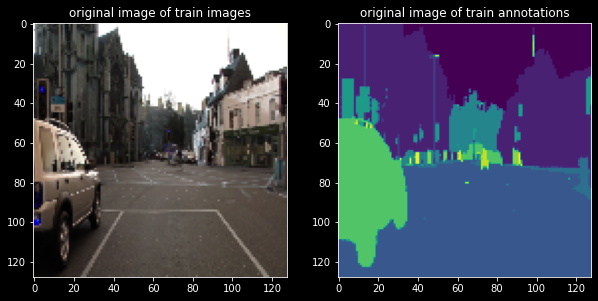

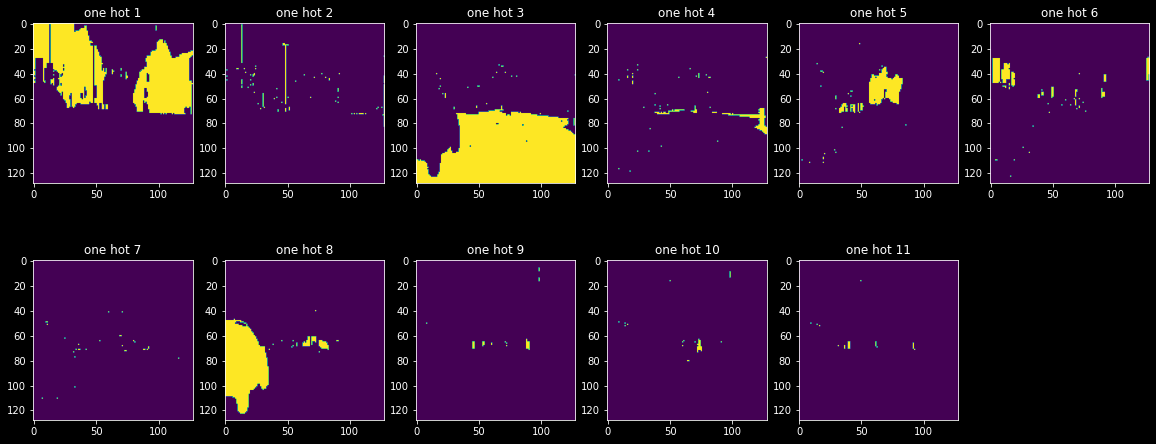

In [27]:
#Plot one hot encoding
fig = plt.figure(figsize = (10,5))
fig2 = plt.figure(figsize = (20,8))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_title("original image of train images")
ax1.imshow(x_train[10], cmap='gray')

ax2.set_title("original image of train annotations")
ax2.imshow(y_train[10])

for index in range(1, 12):
    ax = fig2.add_subplot(2,6, index)
    ax.set_title("one hot {}".format(index))
    ax.imshow(label_train[10][:,:,index])

plt.show()

In [28]:
height = x_train.shape[1]
width = x_train.shape[2]
channel = x_train.shape[3]

In [29]:
#Unet model

inputs = tf.keras.Input((width,height,channel))

conv1 = Conv2D(64, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(inputs)
conv1 = Conv2D(64, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv1)
pool1 = MaxPooling2D(2,2)(conv1)

conv2 = Conv2D(128, 3, activation= 'relu', kernel_initializer='he_normal', padding = 'same')(pool1)
conv2 = Conv2D(128, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(conv2)
pool2 = MaxPooling2D(2,2)(conv2)

conv3 = Conv2D(256, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(pool2)
conv3 = Conv2D(256, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv3)
pool3 = MaxPooling2D(2,2)(conv3)

conv4 = Conv2D(512, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(pool3)
conv4 = Conv2D(512, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv4)
# dropout4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(2,2)(conv4)


conv5 = Conv2D(1024, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(pool4)
conv5 = Conv2D(1024, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(conv5)
dropout5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(dropout5))
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', kernel_initializer='he_normal', padding = 'same')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)
,
up9 = Conv2D(64, 2, activation = 'relu', kernel_initializer='he_normal', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(conv9)

conv9 = Conv2D(64, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(conv9)
conv10 = Conv2D(12, 1, activation = 'softmax')(conv9)

model = tf.keras.Model(inputs,conv10)
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_20[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_21[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 12  780         ['conv2d_22[0][0]']              
                                )                                                                 
                                                                                                  
Total para

In [30]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.85:
                print("\nReached 85% validation accuracy so cancelling training!") 
                self.model.stop_training = True

In [31]:
callbacks = myCallback()


history = model.fit(
    x_train, 
    label_train, 
    validation_data=(x_test, label_test), 
    epochs=50,
    batch_size=4,
    callbacks=[callbacks]
)

Epoch 1/50
74/74 [==============================] - 12s 95ms/step - loss: 1050.1154 - accuracy: 0.3063 - val_loss: 2.9489 - val_accuracy: 0.3591
Epoch 2/50
74/74 [==============================] - 5s 61ms/step - loss: 1.8663 - accuracy: 0.5251 - val_loss: 1.3839 - val_accuracy: 0.6039
Epoch 3/50
74/74 [==============================] - 5s 61ms/step - loss: 1.1642 - accuracy: 0.6483 - val_loss: 1.1215 - val_accuracy: 0.6693
Epoch 4/50
74/74 [==============================] - 5s 61ms/step - loss: 1.0555 - accuracy: 0.6699 - val_loss: 0.9976 - val_accuracy: 0.6988
Epoch 5/50
74/74 [==============================] - 5s 61ms/step - loss: 0.9984 - accuracy: 0.6904 - val_loss: 1.0239 - val_accuracy: 0.7043
Epoch 6/50
74/74 [==============================] - 5s 61ms/step - loss: 0.9703 - accuracy: 0.6997 - val_loss: 0.9290 - val_accuracy: 0.7266
Epoch 7/50
74/74 [==============================] - 5s 62ms/step - loss: 0.9058 - accuracy: 0.7112 - val_loss: 0.8534 - val_accuracy: 0.7360
Epoch 8/5

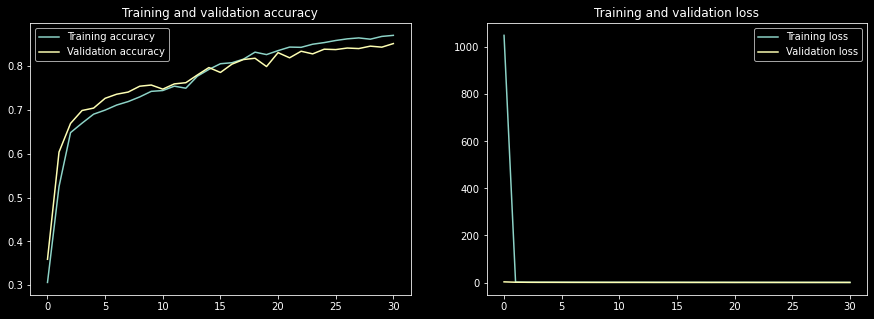

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)


ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(loc=0)

In [33]:
model.save('rtx_model.h5')

In [34]:
load = tf.keras.models.load_model('rtx_model.h5')

In [35]:
y_pred=load.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

3/3 [==============================] - 3s 517ms/step


(74, 128, 128)

In [36]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)   
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.3987632


In [37]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

In [38]:
val = 0
total = 0
res = []

for i in range (n_classes):
    val = values[i,i]
    sum1 = 0
    
    for j in range(n_classes):
        sum1 = values[i,j] + sum1
    sum2 = 0
    
    for x in range(n_classes):
        if x != i:
            sum2 = values[x, i] + sum2  
        else:
            continue
    total = sum1 + sum2
    res.append(val/total)
    print("IoU class {}: {}".format(i,res[i]))

IoU class 0: 0.8919659160073037
IoU class 1: 0.7765567264641448
IoU class 2: 0.06148521082441787
IoU class 3: 0.9298238714846803
IoU class 4: 0.5622561319678725
IoU class 5: 0.5650081809315783
IoU class 6: 0.055978474865467906
IoU class 7: 0.010603238286287434
IoU class 8: 0.6892118098646426
IoU class 9: 0.0030545112781954886
IoU class 10: 0.0010104412260020209
IoU class 11: 0.238204175007149


<BarContainer object of 12 artists>

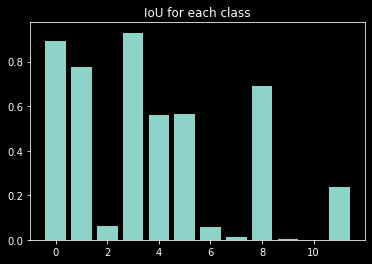

In [39]:
#plot IOU
index = []
for i in range (len(res)):
    index.append(i)
    
plt.title("IoU for each class")
plt.bar(index, res)

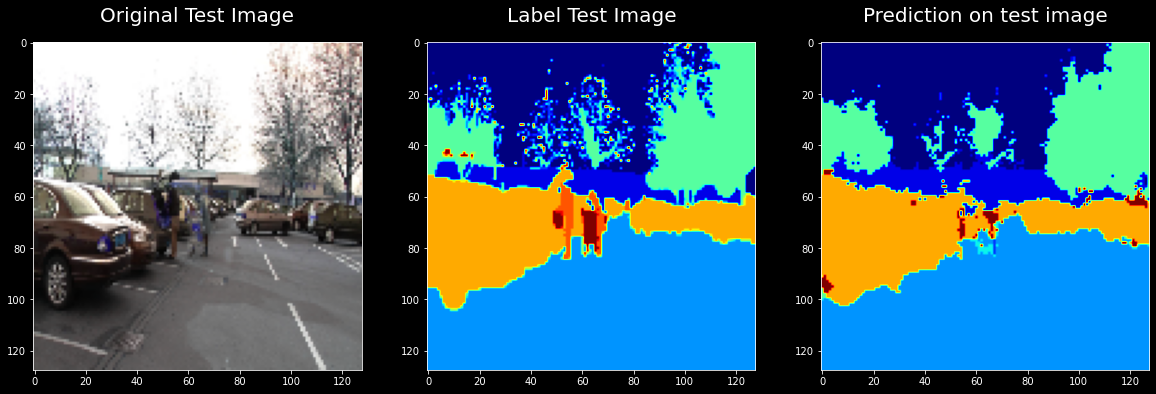

In [40]:
#Plot Prediction Image

num = random.randint(0,len(x_test))
# num = 3

plt.figure(figsize=(20, 20))

plt.subplot(231)
plt.title('Original Test Image', fontsize=20, pad=20)
plt.imshow(x_test[num])

plt.subplot(232)
plt.title('Label Test Image', fontsize=20, pad=20)
plt.imshow(y_test[num].squeeze(), cmap ='jet')

plt.subplot(233)
plt.title('Prediction on test image', fontsize=20, pad=20)
plt.imshow(y_pred_argmax[num], cmap='jet')


plt.show()